# Mongo collections analysis

## Init

In [6]:
import pymongo, math, json, ast, datetime, time, os
import matplotlib.pyplot as plt
from matplotlib import colormaps
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from scipy.stats import entropy
from tqdm import tqdm

from config import Config

image_version = "2.0.0"

image_path = f"images/mongo_analysis/v{image_version}"
if f"v{image_version}" not in os.listdir("images/mongo_analysis"):
    os.mkdir(image_path)


In [7]:
# MongoDB connection settings (replace placeholders with your actual MongoDB connection details)
client = pymongo.MongoClient(Config.MONGO_URI)
db = client[Config.MONGO_DB]
benign = db.benign_2310
misp = db.misp_2311

### TODO

Lexikální
- [x] Histogram výskytů různých TLD
- [x] průměrná délka domény
- [x] průměrná entropie
- [x] Průměrný výskyt jednotlivých skupin znaků (písmenka, čísla, hex, ...)
- [x] Průměrná délka nejkratší, nejdelší, a průměrné části domény
- [x] Průměrný počet subdomén
- [x] Nejtypičtější bigramy a trigramy

IP
- [x]  informace o IP adresách, takže třeba kolik je průměrně IPv4 a IPv6 adres atd

DNS
- [ ] a počty záznamy různých ty
- [ ] o jak se tam pohybují ty ttl hodno
- [ ] y 
Hodně nám tam dominovala ta tls_root_cert_lifeti
- [ ] .. tak se třeba podívat, jak se to pohybuje u phishingových a benign
- [ ] .. jaká je doba platnosi (validity_e
 GEO
- x ] z jakých kontinent
- x ] z jakých  zemí ty domény jso.

## Domain

#### Fetch data from MongoDB

In [8]:
tlds_benign = list(benign.find({}, {'domain_name': 1}))
tlds_misp = list(misp.find({}, {'domain_name': 1}))

### TLDs

#### Definitions

In [9]:
def calculate_column_distribution(df, column, min_percentage):
    """
    Calculate the Top-Level Domain (TLD) distribution in a DataFrame.

    Parameters:
    - df: DataFrame
        The DataFrame containing the 'tld' column.
    - min_percentage: float
        The minimum percentage threshold for considering TLDs.

    Returns:
    - pd.Series
        A Series containing the TLD distribution.
    """
    # Calculate the normalized counts of each column value
    values_counts = df[column].value_counts(normalize=True)
    # Filter column values based on the minimum percentage
    filtered_values = values_counts[values_counts >= min_percentage]
    filtered_values = round(filtered_values * 100, 2)
    # Calculate the sum of counts for column values below the threshold
    others_count = round(values_counts[values_counts < min_percentage].sum() * 100, 2)

    value_names, values_counts = zip(*list(filtered_values.items())+[("Other", others_count)])
    # Return the column values distribution
    return pd.DataFrame(data={
        "name": value_names,
        "count": values_counts
    })

"""
def barplot_column_distribution(df, feature, name, log_scale=False, **kwargs):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="name", y="count", data=df, saturation=1, label=name, **kwargs)
    plt.xlabel(feature)
    plt.ylabel(f'Percentage {"(log)" if "log_scale" in kwargs else ""}')
    yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
    ax.set_yticklabels(yticks_labels)
    ax.bar_label(ax.containers[0])
    plt.title(f'{feature}s - {name}')
    # plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{image_path}/{feature}s - {name}_barplot.png")
    plt.show()
"""
    
def barplot_column_distribution(df, feature, name, log_scale=False, **kwargs):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x="name", y="count", data=df, saturation=1, label=name, **kwargs)

    # Apply logarithmic scale if log_scale is True
    if log_scale:
        ax.set_yscale('log')
        plt.ylabel(f'Percentage (log)')
    else:
        plt.ylabel('Percentage')

    plt.xlabel(feature)
    ax.bar_label(ax.containers[0])
    plt.title(f'{feature}s - {name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{image_path}/{feature}s - {name}_barplot.png")
    plt.show()


def piechart_column_distribution(df, feature, name, color_map=plt.cm.Reds, legend=False, **kwargs):
    plt.figure(figsize=(10, 8))
    logged = np.log(df['count']*10)/5
    scaled = logged / max(logged) * 0.75
    colors = color_map(scaled)
    
    # total_size = sum(sizes)
    scaled=[0.5 for x in range(len(df))]
    wedges, texts, autotexts = plt.pie(df['count'], labels=df['name'], autopct='%1.1f%%', startangle=90, pctdistance=0.8)

    # Increase font size for labels and autotexts
    for text in texts:
        text.set_fontsize(12)  # Bigger font size
    for autotext in autotexts:
        autotext.set_color('white')  # White font color
        autotext.set_fontsize(12)  # Bigger font size
    
    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
        # Hide labels around the circle
        for text in texts:
            text.set_visible(False)

    plt.title(f'{feature}s - {name}')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    # plt.tight_layout()
    if legend:
        plt.savefig(f"{image_path}/{feature}s_{name}_piechart_w_legend.png")
        plt.savefig(f"{image_path}/{feature}s_{name}_piechart_w_legend.pdf", format='pdf')
    else:
        plt.savefig(f"{image_path}/{feature}s_{name}_piechart.png")
        plt.savefig(f"{image_path}/{feature}s_{name}_piechart.pdf", format='pdf')

    plt.show()
    
    
    
def piechart_column_distribution2(df, feature, name, color_map=plt.cm.tab10, legend=False, **kwargs):
    plt.figure(figsize=(10, 8))
    
    # Combine two different color maps
    color_map1 = plt.cm.tab20(np.linspace(0., 1., 20))
    color_map2 = plt.cm.tab10(np.linspace(0., 1., 20))  # Set3 has 12 distinct colors
    combined_colors = np.vstack((color_map1, color_map2))  # Stack the color maps

    # Shuffle the combined color map to ensure variety
    #np.random.shuffle(combined_colors)

    # Assign colors to each category, ensuring 'Other' is set to grey
    colors = [combined_colors[i] if tld != "Other" else 'grey' for i, tld in enumerate(df['name'])]


    # Create the pie chart without autopct
    wedges, texts = plt.pie(df['count'], startangle=90, colors=colors, **kwargs)

    # Determine the angle and percentage for each wedge
    angles = [(w.theta2 + w.theta1) / 2 for w in wedges]
    percentages = [100. * c / sum(df['count']) for c in df['count']]
    labels = [f"{tld} {pct:.1f}%" for tld, pct in zip(df['name'], percentages)]

    # Initialize a list to keep track of text positions
    positions = []

    # Function to check if the new label overlaps with previous labels
    def check_overlap(new_pos, positions, threshold=0.05):
        for pos in positions:
            if abs(new_pos - pos) < threshold:  # If overlap within a threshold
                return True
        return False

    # Annotate with TLD and percentage
    for angle, label in zip(angles, labels):
        x = np.cos(np.deg2rad(angle))
        y = np.sin(np.deg2rad(angle))

        # Initialize position for the label
        init_y = y

        # Check for overlap and adjust position if necessary
        while check_overlap(init_y, positions):
            init_y += np.sign(y) * 0.05  # Move up or down depending on sign of y

        # Add the position to the list
        positions.append(init_y)

        # Set the new position for annotation
        distance_from_center = 1.5
        xytext = (distance_from_center * np.sign(x), distance_from_center * init_y)

        plt.annotate(label, xy=(x, y), xytext=xytext,
                     textcoords='data', ha='center', va='center',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"),
                     fontsize=16)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

    plt.title(f'{feature}s - {name}', fontsize=14)
    plt.axis('equal')

    # Assuming 'image_path' is a predefined variable pointing to the directory where the image is to be saved.
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.png")
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.pdf", format='pdf')

    plt.show()


def piechart_column_distribution3(df, feature, name, color_map=plt.cm.tab10, legend=False, **kwargs):
    plt.figure(figsize=(10, 8))
    
    # Combine two different color maps
    color_map1 = plt.cm.tab20(np.linspace(0., 1., 20))
    color_map2 = plt.cm.tab10(np.linspace(0., 1., 12))  # tab10 has 12 distinct colors
    combined_colors = np.vstack((color_map1, color_map2))  # Stack the color maps

    # Assign colors to each category, ensuring 'Other' is set to grey
    colors = [combined_colors[i] if tld != "Other" else 'grey' for i, tld in enumerate(df['name'])]

    # Create the pie chart without autopct
    wedges, texts = plt.pie(df['count'], startangle=90, colors=colors, **kwargs)

    # Calculate the percentages and set up the labels
    percentages = [100. * c / sum(df['count']) for c in df['count']]
    labels = [f"{tld} {pct:.1f}%" for tld, pct in zip(df['name'], percentages)]

    # Annotate with TLD and percentage
    for i, (wedge, label) in enumerate(zip(wedges, labels)):
        ang = (wedge.theta2 + wedge.theta1) / 2
        x = np.cos(np.deg2rad(ang))
        y = np.sin(np.deg2rad(ang))

        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle=connectionstyle),
                  horizontalalignment=horizontalalignment, size=12, color=combined_colors[i], va='center')

        plt.annotate(label, xy=(x, y), xytext=(1.5*x, 1.2*y), **kw)

    if legend:
        plt.legend(wedges, df['name'], title=f"{feature}s", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=16)

    plt.title(f'{feature}s - {name}', fontsize=14)
    plt.axis('equal')

    # Adjust the margins and save the figure with enough space for the content
    plt.subplots_adjust(left=0.0, right=0.85, top=0.9, bottom=0.1)  # Adjust as needed
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.png", bbox_inches='tight')
    plt.savefig(f"{image_path}/{feature}s_{name}_piechart.pdf", format='pdf', bbox_inches='tight')

    plt.show()

# Example usage:
# piechart_column_distribution2(phishing_tld_dist, feature_name, "Phishing")

    

#### Compute the values

In [10]:
# Create DataFrames
df_benign = pd.DataFrame(tlds_benign)
df_misp = pd.DataFrame(tlds_misp)

df_benign["tld"] = df_benign["domain_name"].apply(lambda x: x.split(".")[-1])
df_misp["tld"] = df_misp["domain_name"].apply(lambda x: x.split(".")[-1])


min_percentage = 0.005
#min_percentage = 0.001


# Calculate distributions
benign_tld_dist = calculate_column_distribution(df_benign, "tld", min_percentage)
misp_tld_dist = calculate_column_distribution(df_misp, "tld", min_percentage)

misp_tld_dist = calculate_column_distribution(df_misp, "tld", 0.01)


In [11]:
"""
# Assuming calculate_column_distribution is a function that takes a DataFrame and a column name,
# and returns a new DataFrame with the distribution percentage of each unique value in the column.

def calculate_column_distribution(df, column, min_percentage):
    # This is a placeholder for the actual implementation of the function
    # It should calculate the frequency of each unique value in the specified column
    # and return a DataFrame with the values and their corresponding percentage.
    distribution = df[column].value_counts(normalize=True)
    filtered_distribution = distribution[distribution >= min_percentage]
    return filtered_distribution.rename_axis('tld').reset_index(name='percentage')

# Example usage of the function (you would replace this with the actual implementation)
benign_tld_dist = calculate_column_distribution(df_benign, "tld", min_percentage)
misp_tld_dist = calculate_column_distribution(df_misp, "tld", min_percentage)

# Now to print the top 100 TLDs from benign and misp DataFrames
print("Top 100 TLDs in Benign Dataset")
print(benign_tld_dist.head(100).to_string(index=False))
print("\nTop 100 TLDs in MISP Dataset")
print(misp_tld_dist.head(100).to_string(index=False))
"""

'\n# Assuming calculate_column_distribution is a function that takes a DataFrame and a column name,\n# and returns a new DataFrame with the distribution percentage of each unique value in the column.\n\ndef calculate_column_distribution(df, column, min_percentage):\n    # This is a placeholder for the actual implementation of the function\n    # It should calculate the frequency of each unique value in the specified column\n    # and return a DataFrame with the values and their corresponding percentage.\n    distribution = df[column].value_counts(normalize=True)\n    filtered_distribution = distribution[distribution >= min_percentage]\n    return filtered_distribution.rename_axis(\'tld\').reset_index(name=\'percentage\')\n\n# Example usage of the function (you would replace this with the actual implementation)\nbenign_tld_dist = calculate_column_distribution(df_benign, "tld", min_percentage)\nmisp_tld_dist = calculate_column_distribution(df_misp, "tld", min_percentage)\n\n# Now to prin

In [12]:
logged = np.log(benign_tld_dist['count']*10)/10
logged / max(logged) * 0.75

0     0.750000
1     0.605017
2     0.391875
3     0.338474
4     0.286008
5     0.283954
6     0.253334
7     0.217380
8     0.203815
9     0.195295
10    0.565321
Name: count, dtype: float64

#### Plot the results

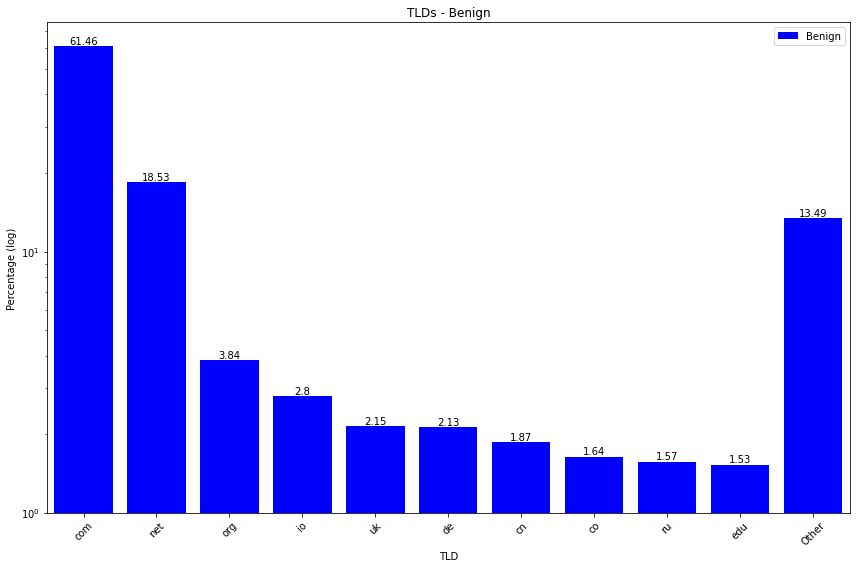

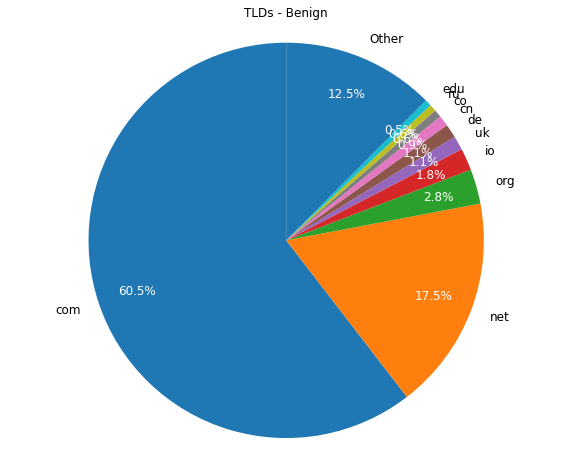

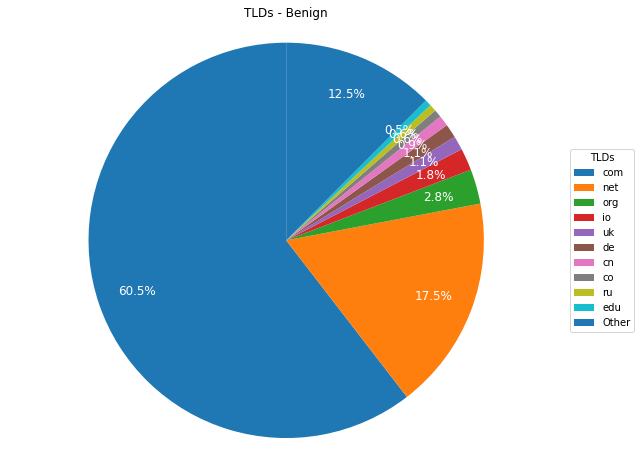

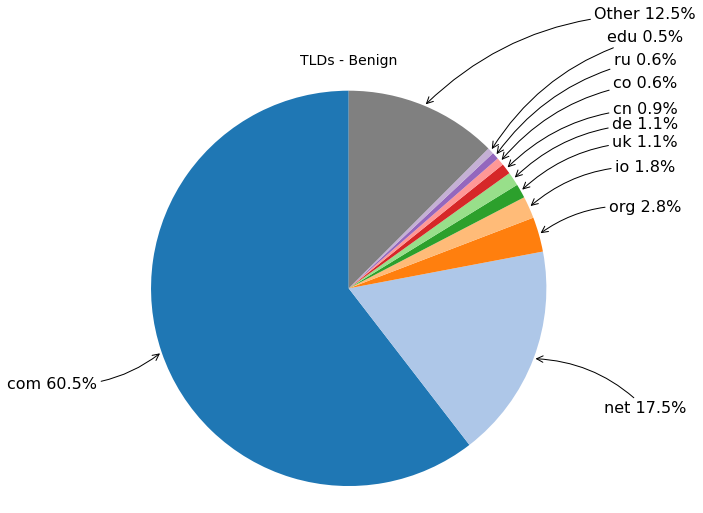

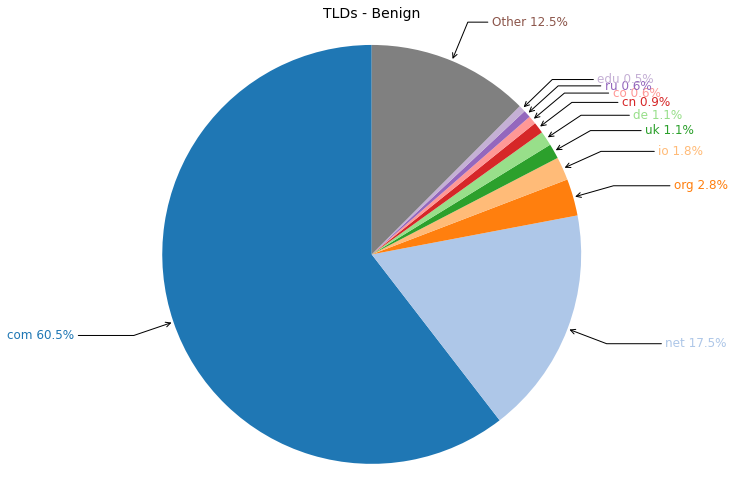

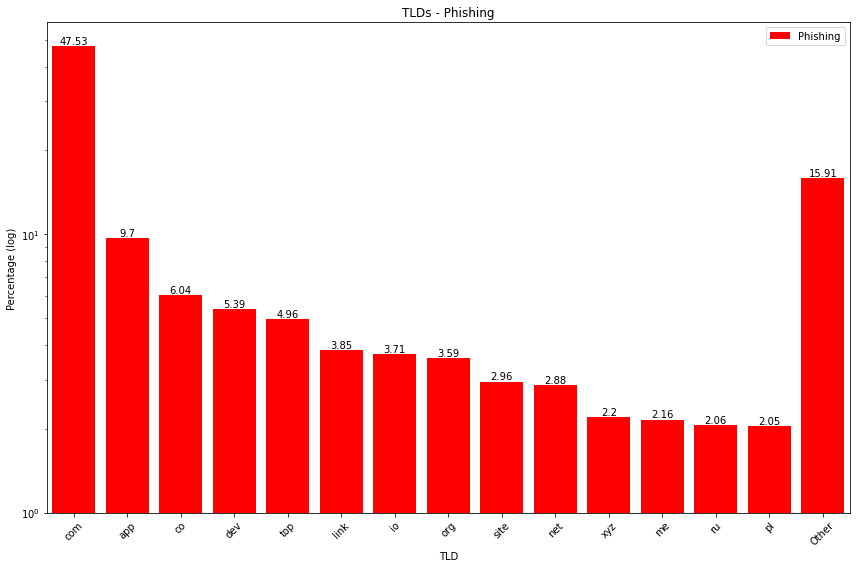

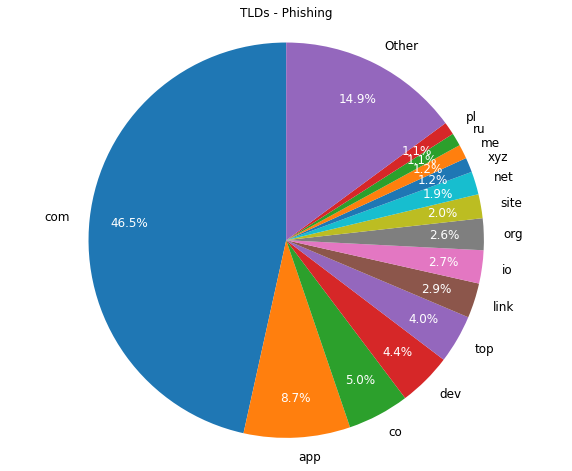

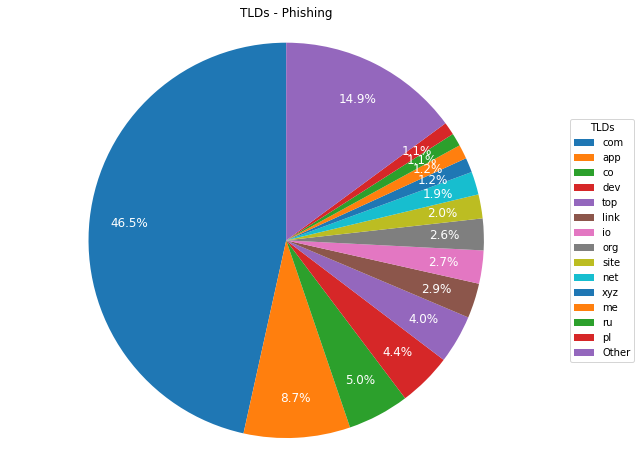

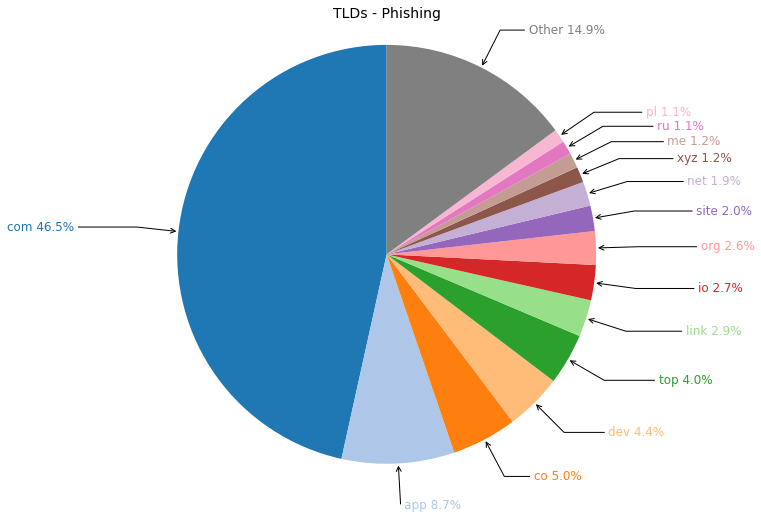

In [44]:
feature_name = "Top-Level Domain"
feature_name = "TLD"

# Plot the Benign data
barplot_column_distribution(benign_tld_dist, feature_name, "Benign", color="b", log_scale=True, bottom=1e-0)
piechart_column_distribution(benign_tld_dist, feature_name, "Benign")
piechart_column_distribution(benign_tld_dist, feature_name, "Benign", legend=True)
piechart_column_distribution2(benign_tld_dist, feature_name, "Benign")
piechart_column_distribution3(benign_tld_dist, feature_name, "Benign")
# Plot the Phishing data
barplot_column_distribution(misp_tld_dist, feature_name, "Phishing", color="r", log_scale=True, bottom=1e-0)
piechart_column_distribution(misp_tld_dist, feature_name, "Phishing")
piechart_column_distribution(misp_tld_dist, feature_name, "Phishing", legend=True)
piechart_column_distribution3(misp_tld_dist, feature_name, "Phishing")


### Lexical domain analysis (Averages)

#### Definitions

In [45]:
def calculate_entropy(string):
    prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
    return - sum([p * math.log(p) / math.log(2.0) for p in prob])

# Functions for domain characteristic calculations
def average_domain_length(domains):
    lengths = [len(domain) for domain in domains]
    return sum(lengths) / len(lengths)

def average_entropy(domains):

    entropies = [calculate_entropy(domain) for domain in domains]
    return sum(entropies) / len(entropies)

def average_char_groups(domains):
    letter_count = 0
    number_count = 0
    hex_count = 0
    other_count = 0

    for domain in domains:
        for char in domain:
            if char.isalpha():
                letter_count += 1
                if char in ['a', 'b', 'c', 'd', 'e', 'f', 'A', 'B', 'C', 'D', 'E', 'F']:
                    hex_count += 1
            elif char.isdigit():
                number_count += 1
                hex_count += 1
            else:
                other_count += 1

    total_chars = letter_count + number_count + other_count
    return {
        'letters': letter_count / total_chars,
        'numbers': number_count / total_chars,
        'hex': hex_count / total_chars,
        'other': other_count / total_chars
    }

def average_shortest_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    shortest_parts = [min(parts, key=len) for parts in domain_parts]
    return sum(len(part) for part in shortest_parts) / len(shortest_parts)


def average_longest_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    longest_parts = [max(parts, key=len) for parts in domain_parts]
    return sum(len(part) for part in longest_parts) / len(longest_parts)


def average_average_part_length(domains):
    domain_parts = [domain.split('.') for domain in domains]
    avg_lengths = [sum(len(part) for part in parts) / len(parts) if parts else 0 for parts in domain_parts]
    return sum(avg_lengths) / len(avg_lengths) if avg_lengths else 0


def average_subdomains_count(domains):
    subdomain_count = [domain.count('.') for domain in domains]
    return sum(subdomain_count) / len(subdomain_count)


#### Compute the values

In [46]:
# Fetching domain data from MongoDB collections
print("Fetching data from MongoDB collections...")
benign_domains = [entry['domain_name'] for entry in benign.find({}, {'domain_name': 1})]
misp_domains = [entry['domain_name'] for entry in misp.find({}, {'domain_name': 1})]

# Calculate domain characteristics
print("Calculating domain characteristics...")


benign_char_groups = average_char_groups(benign_domains)
benign_characteristics = {
    'AVG Domain Name Length': average_domain_length(benign_domains),
    'AVG Domain Name Entropy': average_entropy(benign_domains),
    'Letters Appearance': benign_char_groups["letters"],
    'Numbers Appearance': benign_char_groups["numbers"],
    'Hex Appearance': benign_char_groups["hex"],
    'Other Appearance': benign_char_groups["other"],
    'AVG Shortest Part Len': average_shortest_part_length(benign_domains),
    'AVG Longest Part Len': average_longest_part_length(benign_domains),
    'AVG Average Part Len': average_average_part_length(benign_domains),
    'AVG Subdomain Count': average_subdomains_count(benign_domains)
}

misp_char_groups = average_char_groups(misp_domains)
misp_characteristics = {
    'AVG Domain Name Length': average_domain_length(misp_domains),
    'AVG Domain Name Entropy': average_entropy(misp_domains),
    'Letters Appearance': misp_char_groups["letters"],
    'Numbers Appearance': misp_char_groups["numbers"],
    'Hex Appearance': misp_char_groups["hex"],
    'Other Appearance': misp_char_groups["other"],
    'AVG Shortest Part Len': average_shortest_part_length(misp_domains),
    'AVG Longest Part Len': average_longest_part_length(misp_domains),
    'AVG Average Part Len': average_average_part_length(misp_domains),
    'AVG Subdomain Count': average_subdomains_count(misp_domains)
}

# Print domain characteristics for each collection
print("\nBenign Characteristics:")
for key, value in benign_characteristics.items():
    print(f"{key}: {round(value, 5)}")
print("\nMISP Characteristics:")
for key, value in misp_characteristics.items():
    print(f"{key}: {round(value, 5)}")


Fetching data from MongoDB collections...
Calculating domain characteristics...

Benign Characteristics:
AVG Domain Name Length: 22.24783
AVG Domain Name Entropy: 3.53636
Letters Appearance: 0.81972
Numbers Appearance: 0.0516
Hex Appearance: 0.31798
Other Appearance: 0.12867
AVG Shortest Part Len: 2.71471
AVG Longest Part Len: 10.65587
AVG Average Part Len: 6.12801
AVG Subdomain Count: 2.26015

MISP Characteristics:
AVG Domain Name Length: 29.35377
AVG Domain Name Entropy: 3.8134
Letters Appearance: 0.79232
Numbers Appearance: 0.10952
Hex Appearance: 0.38137
Other Appearance: 0.09816
AVG Shortest Part Len: 2.84886
AVG Longest Part Len: 17.33266
AVG Average Part Len: 8.65148
AVG Subdomain Count: 2.10735


#### Plot the results

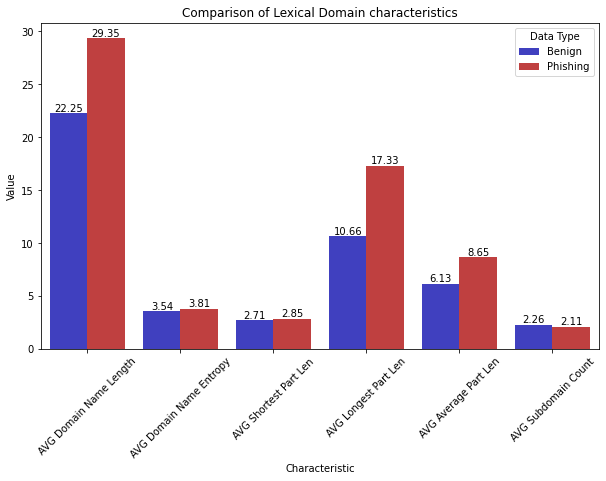

/tmp/ipykernel_1096675/3695598338.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks_labels)


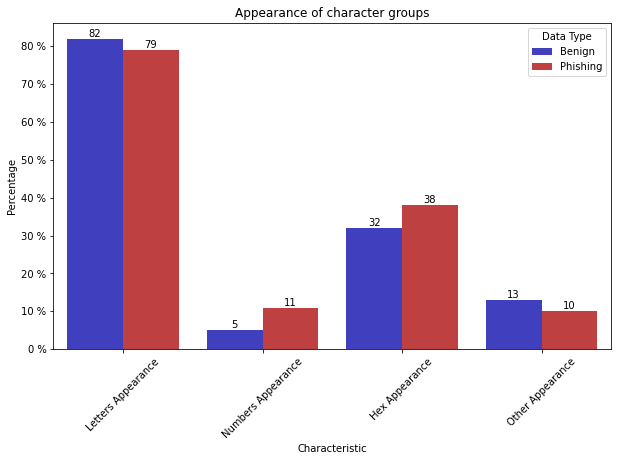

In [47]:
# Visualize the comparison
data_avg = {
    'Characteristic': [],
    'Benign': [],
    'Phishing': []
}

data_appearance = {
    'Characteristic': [],
    'Benign': [],
    'Phishing': []
}

for characteristic in benign_characteristics:
    data = data_avg if "AVG" in characteristic else data_appearance
    data['Characteristic'].append(characteristic)
    data['Benign'].append(round(benign_characteristics[characteristic], 2))
    data['Phishing'].append(round(misp_characteristics[characteristic], 2))

for data, percentages, title in (
    (data_avg, False, "Comparison of Lexical Domain characteristics"), 
    (data_appearance, True, "Appearance of character groups")
):
    # Convert to DataFrame
    df = pd.DataFrame(data)

    if percentages:
        df['Benign'] = df['Benign'] * 100
        df['Phishing'] = df['Phishing'] * 100
    
    # Melt the DataFrame for better visualization
    df_melted = df.melt('Characteristic', var_name='Data Type', value_name='Value')
    
    # Plotting
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Characteristic', y='Value', hue='Data Type', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5)
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    plt.title(title)
    plt.xticks(rotation=45)

    if percentages:
        plt.ylabel('Percentage')
        yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
        ax.set_yticklabels(yticks_labels)

    plt.savefig(f"{image_path}/{title}_barplot.png")
    
    # Saving as PNG
    png_file_path = f"{image_path}/{title}_barplot.pdf"
    plt.savefig(png_file_path, format='png', dpi=300)
    
    # Saving as PDF (vector format)
    pdf_file_path = f"{image_path}/{title}_barplot.pdf"
    plt.savefig(pdf_file_path, format='pdf')
    
    plt.show()

0.5647984612966165
0.3245358652875514


/tmp/ipykernel_1096675/2972331955.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Ratio', y='Dataset', data=df_to_plot, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


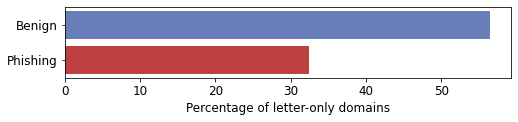

In [90]:
benign_lo = 0
phishing_lo = 0

for domain in benign_domains:
    if all(c.isalpha() or c == '.' for c in domain):
        benign_lo += 1
        
for domain in misp_domains:
    if all(c.isalpha() or c == '.' for c in domain):
        phishing_lo += 1

benign_lo_ratio = benign_lo / len(benign_domains)
phishing_lo_ratio = phishing_lo / len(misp_domains)

print(benign_lo_ratio)
print(phishing_lo_ratio)

# Data for plotting
data_to_plot = {
    'Dataset': ['Benign', 'Phishing'],
    'Ratio': [benign_lo_ratio * 100, phishing_lo_ratio * 100]
}

df_to_plot = pd.DataFrame(data_to_plot)

# Plotting
plt.figure(figsize=(8, 1.3))
sns.barplot(x='Ratio', y='Dataset', data=df_to_plot, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)
#plt.title('Percentage of letter-only domains')
plt.xlabel('Percentage of letter-only domains', fontsize=12)
#plt.ylabel('Dataset')  # Correct usage as a function to set the ylabel
plt.ylabel('')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

pdf_file_path = f"{image_path}/lex_lo.pdf"
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight')
    

plt.show()


### Lexical - data collection and Boxplots

In [92]:
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn._oldcore")

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

# Function to calculate the percentage of character types in a domain
def calculate_character_type_percentages(domain):
    
    domain.replace(".", "") # removealldots
    
    letters = sum(c.isalpha() for c in domain)
    numbers = sum(c.isdigit() for c in domain)
    hex_symbols = sum(c in string.hexdigits for c in domain)
    special_symbols = sum(not c.isalnum() for c in domain)
    total = len(domain)

    return {
        'The percentage of letters': (letters / total) * 100 if total > 0 else 0,
        'The percentage of numbers': (numbers / total) * 100 if total > 0 else 0,
        'The percentage of hex symbols': (hex_symbols / total) * 100 if total > 0 else 0,
        #'The percentage of special symbols': (special_symbols / total) * 100 if total > 0 else 0,
        'The percentage of hyphens': (special_symbols / total) * 100 if total > 0 else 0,
    }

# Extend the collect_data function to include the new percentages
def collect_data(domains):
    data = {
        'Domain name length': [len(domain) for domain in domains],
        'Domain name entropy': [calculate_entropy(domain) for domain in domains],
        'Domain name length': [len(domain) for domain in domains],
        'Domain name entropy': [calculate_entropy(domain) for domain in domains],
        'Shortest part length': [len(min(domain.split('.'), key=len)) for domain in domains],
        'Longest part length': [len(max(domain.split('.'), key=len)) for domain in domains],
        'Average part length': [sum(len(part) for part in domain.split('.')) / len(domain.split('.')) for domain in domains],
        'Subdomain count': [domain.count('.') for domain in domains],
        # Add more characteristics if needed
    }

    # Add the new percentages to the data
    for domain in domains:
        percentages = calculate_character_type_percentages(domain)
        for key, value in percentages.items():
            if key not in data:
                data[key] = []
            data[key].append(value)

    return data

# ... (rest of your existing code)


# Collect data for benign and misp domains
benign_data = collect_data(benign_domains)
misp_data = collect_data(misp_domains)



In [93]:
# Padding with NaNs (for boxplots)

import numpy as np

# Determine the maximum length
max_length = max(len(benign_domains), len(misp_domains))

# Function to pad lists to the same length
def pad_list(lst, length):
    return lst + [np.nan] * (length - len(lst))

# Pad the data for benign and misp domains
padded_benign_data = {key: pad_list(value, max_length) for key, value in benign_data.items()}
padded_misp_data = {key: pad_list(value, max_length) for key, value in misp_data.items()}


In [94]:
# Function to calculate statistics, handling NaN values
def calculate_statistics(data):
    valid_data = [d for d in data if not np.isnan(d)]
    return {
        'Count': len(valid_data),
        'Min': np.min(valid_data),
        'Max': np.max(valid_data),
        'Mean': np.mean(valid_data),
        'Median': np.median(valid_data)
    }

benign_stats = None
phishing_stats = None

# Calculating and printing statistics for each characteristic
for characteristic in benign_data:  # Assuming benign_data and misp_data are the original data
    benign_stats = calculate_statistics(benign_data[characteristic])
    phishing_stats = calculate_statistics(misp_data[characteristic])

    print(f"Characteristic: {characteristic}")
    print(f"  Benign - Count: {benign_stats['Count']}, Min: {benign_stats['Min']}, Max: {benign_stats['Max']}, Mean: {benign_stats['Mean']:.2f}, Median: {benign_stats['Median']}")
    print(f"  Phishing - Count: {phishing_stats['Count']}, Min: {phishing_stats['Min']}, Max: {phishing_stats['Max']}, Mean: {phishing_stats['Mean']:.2f}, Median: {phishing_stats['Median']}")
    print("\n")

Characteristic: Domain name length
  Benign - Count: 432572, Min: 4, Max: 150, Mean: 22.25, Median: 20.0
  Phishing - Count: 68353, Min: 4, Max: 110, Mean: 29.35, Median: 26.0


Characteristic: Domain name entropy
  Benign - Count: 432572, Min: 0.5916727785823274, Max: 4.87909162862676, Mean: 3.54, Median: 3.550340709546388
  Phishing - Count: 68353, Min: 0.7219280948873623, Max: 4.930931186916805, Mean: 3.81, Median: 3.833371693654795


Characteristic: Shortest part length
  Benign - Count: 432572, Min: 1, Max: 26, Mean: 2.71, Median: 3.0
  Phishing - Count: 68353, Min: 1, Max: 10, Mean: 2.85, Median: 3.0


Characteristic: Longest part length
  Benign - Count: 432572, Min: 2, Max: 63, Mean: 10.66, Median: 10.0
  Phishing - Count: 68353, Min: 2, Max: 63, Mean: 17.33, Median: 13.0


Characteristic: Average part length
  Benign - Count: 432572, Min: 1.3333333333333333, Max: 32.5, Mean: 6.13, Median: 5.666666666666667
  Phishing - Count: 68353, Min: 1.5, Max: 28.333333333333332, Mean: 8.6

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


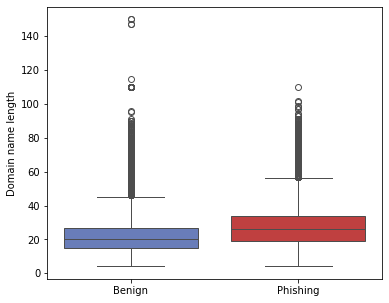

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


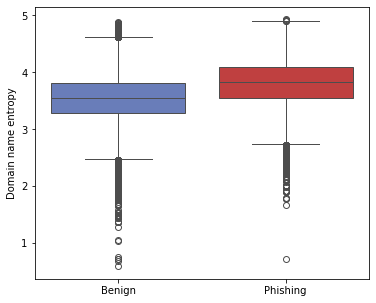

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


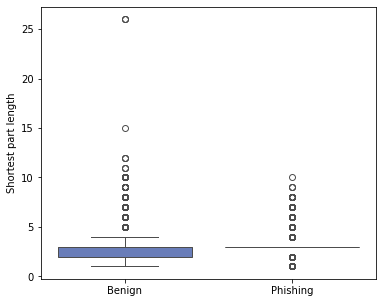

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


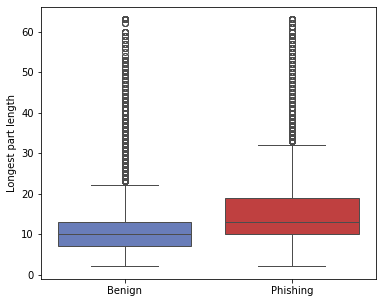

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


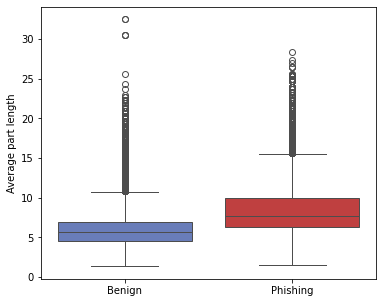

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


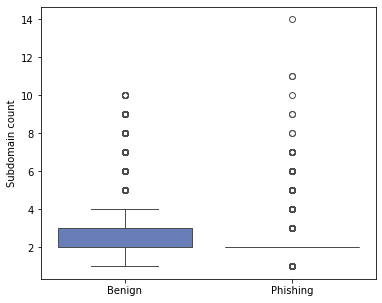

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


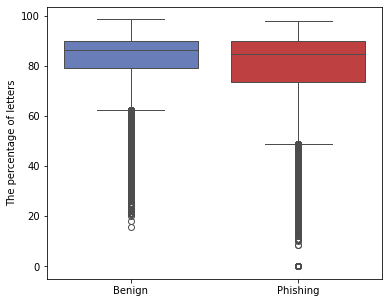

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


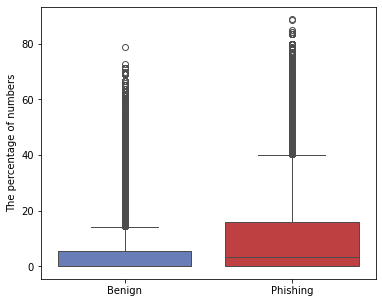

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


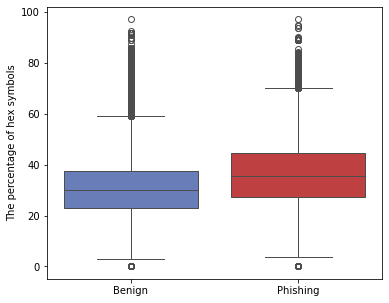

/tmp/ipykernel_1096675/198747741.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


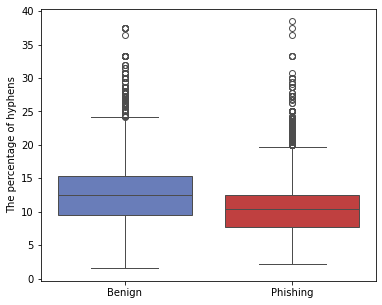

In [83]:
# BOXPLOTS
# Visualize the comparison
for characteristic in padded_benign_data:
    plt.figure(figsize=(6, 5))
    # Combine benign and phishing data into one DataFrame for plotting
    df = pd.DataFrame({
        'Benign': padded_benign_data[characteristic],
        'Phishing': padded_misp_data[characteristic]
    })

    # Melt the DataFrame for better visualization
    df_melted = df.melt(var_name='Domain Class', value_name=characteristic)

    # Plotting
    ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)
    #plt.title(f"The distribu6tion of {characteristic}")

    ax.set_xlabel('') 
    # ax.set_xticks([])
    
    # Saving as PNG
    png_file_path = f"{image_path}/Boxplot_{characteristic}.png"
    plt.savefig(png_file_path, format='png', dpi=300)

    # Saving as PDF (vector format)
    pdf_file_path = f"{image_path}/Boxplot_{characteristic}.pdf"
    plt.savefig(pdf_file_path, format='pdf')

    plt.show()


In [84]:
"""
# BOXPLOTS with statistics
# Visualize the comparison
for characteristic in padded_benign_data:
    plt.figure(figsize=(8, 6))  # Adjust the size for better visualization
    # Combine benign and phishing data into one DataFrame for plotting
    df = pd.DataFrame({
        'Benign': padded_benign_data[characteristic],
        'Phishing': padded_misp_data[characteristic]
    })

    # Melt the DataFrame for better visualization
    df_melted = df.melt(var_name='Domain Class', value_name=characteristic)

    # Plotting
    ax = sns.boxplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)
    plt.title(f"The distribution of {characteristic}")

    # Annotate statistics
    _benign_stats = benign_stats[characteristic]
    _phishing_stats = phishing_stats[characteristic]
    stats_text = (f"Benign - Min: {_benign_stats['Min']}, Max: {_benign_stats['Max']}, "
                  f"Mean: {_benign_stats['Mean']:.2f}, Median: {_benign_stats['Median']}\n"
                  f"Phishing - Min: {_phishing_stats['Min']}, Max: {_phishing_stats['Max']}, "
                  f"Mean: {_phishing_stats['Mean']:.2f}, Median: {_phishing_stats['Median']}")
    plt.figtext(0.5, -0.1, stats_text, wrap=True, horizontalalignment='center', fontsize=10)

    # Adjust layout for better fit
    plt.tight_layout()

    # Saving as PNG and PDF
    png_file_path = f"{image_path}/Boxplot_{characteristic}.png"
    pdf_file_path = f"{image_path}/Boxplot_{characteristic}.pdf"
    plt.savefig(png_file_path, format='png', dpi=300)
    plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight')  # bbox_inches='tight' to include annotations

    plt.show()
"""

'\n# BOXPLOTS with statistics\n# Visualize the comparison\nfor characteristic in padded_benign_data:\n    plt.figure(figsize=(8, 6))  # Adjust the size for better visualization\n    # Combine benign and phishing data into one DataFrame for plotting\n    df = pd.DataFrame({\n        \'Benign\': padded_benign_data[characteristic],\n        \'Phishing\': padded_misp_data[characteristic]\n    })\n\n    # Melt the DataFrame for better visualization\n    df_melted = df.melt(var_name=\'Domain Class\', value_name=characteristic)\n\n    # Plotting\n    ax = sns.boxplot(x=\'Domain Class\', y=characteristic, data=df_melted, palette={\'Benign\': \'royalblue\', \'Phishing\': \'red\'}, saturation=0.5)\n    plt.title(f"The distribution of {characteristic}")\n\n    # Annotate statistics\n    _benign_stats = benign_stats[characteristic]\n    _phishing_stats = phishing_stats[characteristic]\n    stats_text = (f"Benign - Min: {_benign_stats[\'Min\']}, Max: {_benign_stats[\'Max\']}, "\n                  f

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


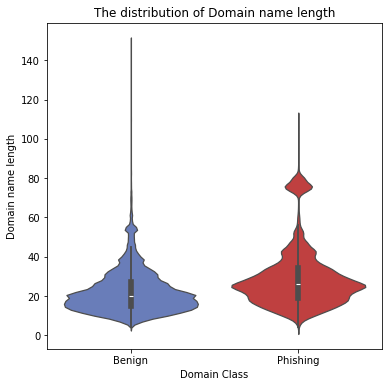

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


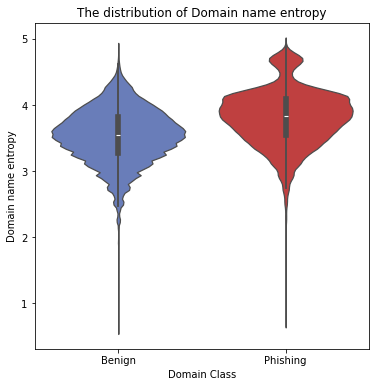

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


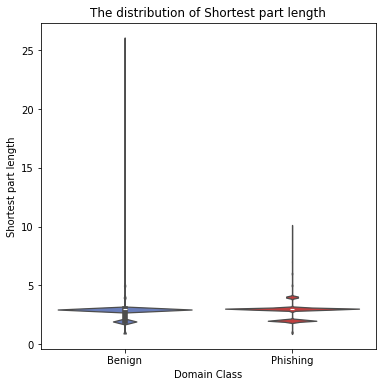

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


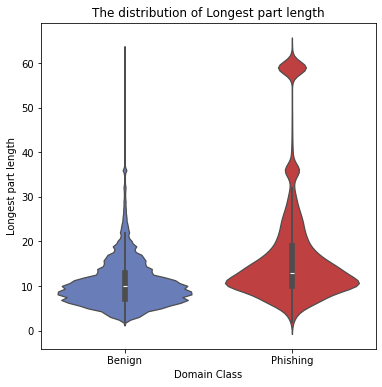

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


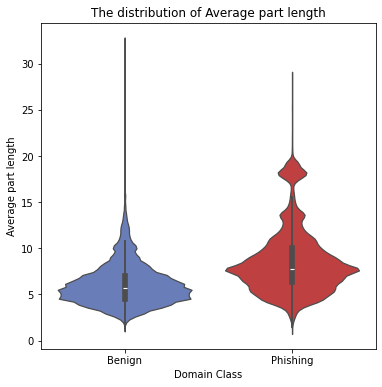

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


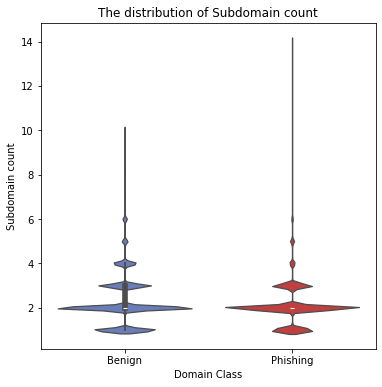

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


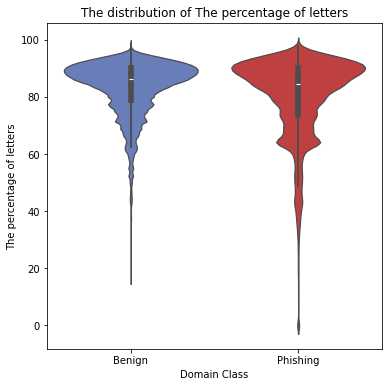

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


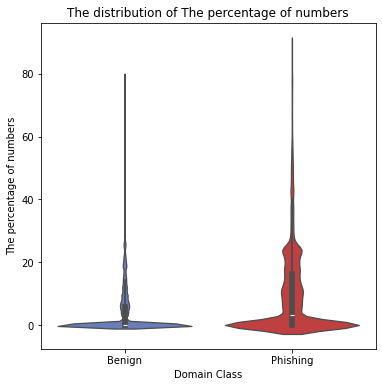

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


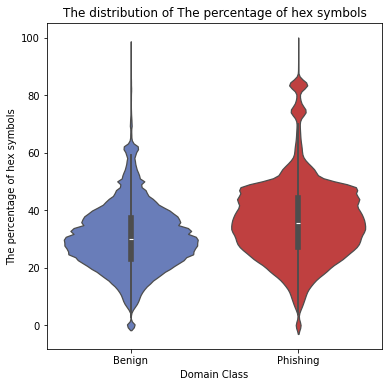

/tmp/ipykernel_1096675/2178912746.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


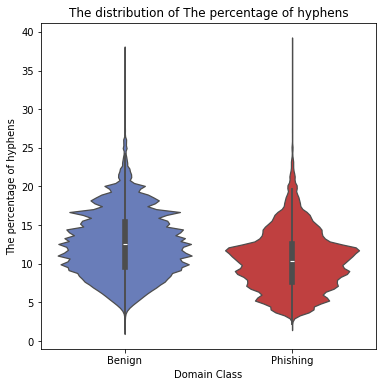

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Visualize the comparison using violin plots
for characteristic in padded_benign_data:
    plt.figure(figsize=(6, 6))
    # Combine benign and phishing data into one DataFrame for plotting
    df = pd.DataFrame({
        'Benign': padded_benign_data[characteristic],
        'Phishing': padded_misp_data[characteristic]
    })

    # Melt the DataFrame for better visualization
    df_melted = df.melt(var_name='Domain Class', value_name=characteristic)

    # Plotting using violin plot
    ax = sns.violinplot(x='Domain Class', y=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)
    plt.title(f"The distribution of {characteristic}")

    # Saving as PNG
    png_file_path = f"{image_path}/ViolinPlot_{characteristic}.png"
    plt.savefig(png_file_path, format='png', dpi=300)

    # Saving as PDF (vector format)
    pdf_file_path = f"{image_path}/ViolinPlot_{characteristic}.pdf"
    plt.savefig(pdf_file_path, format='pdf')

    plt.show()


/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


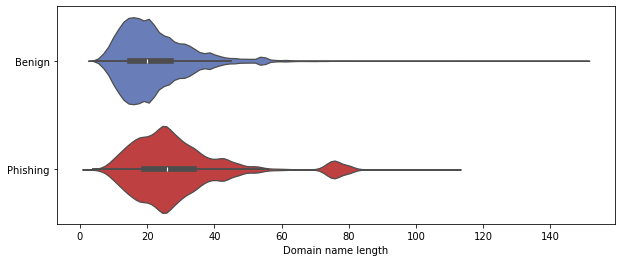

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


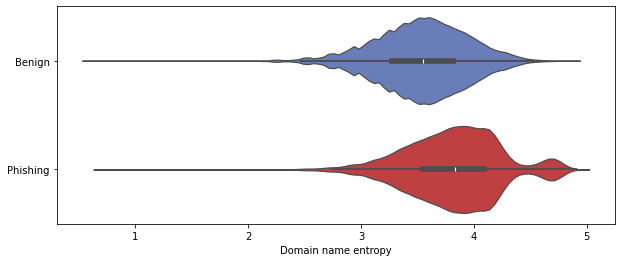

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


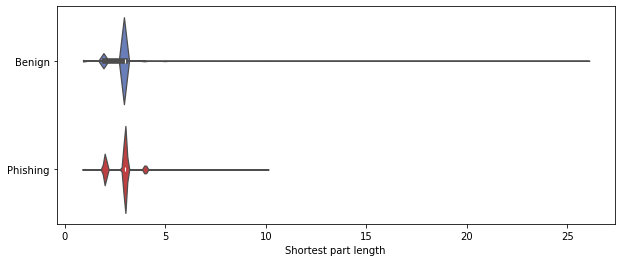

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


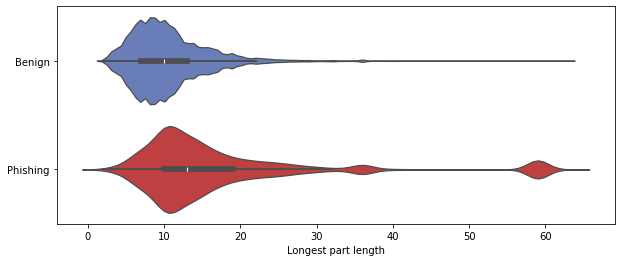

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


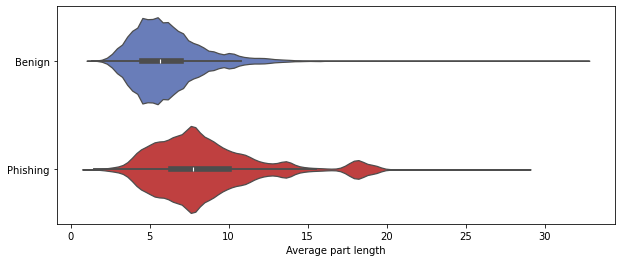

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


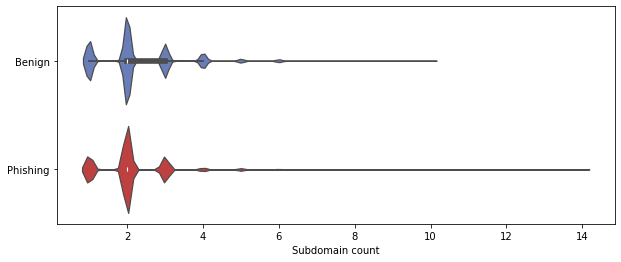

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


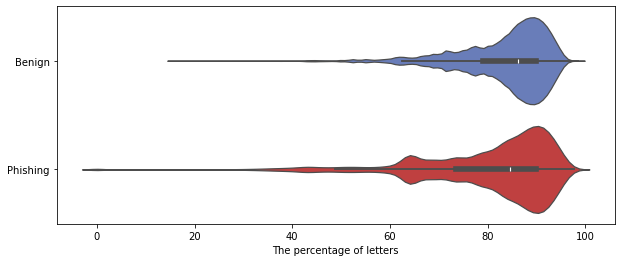

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


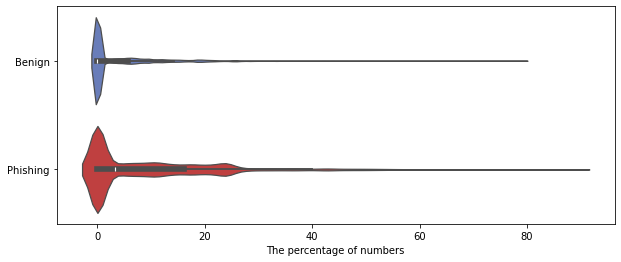

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


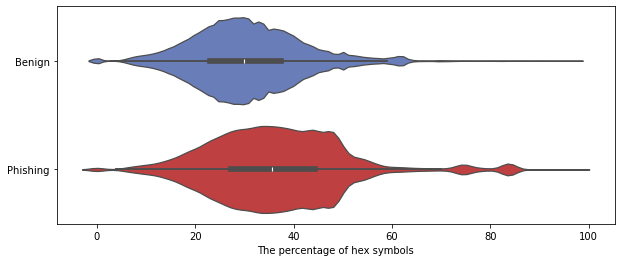

/tmp/ipykernel_1096675/2479682627.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)


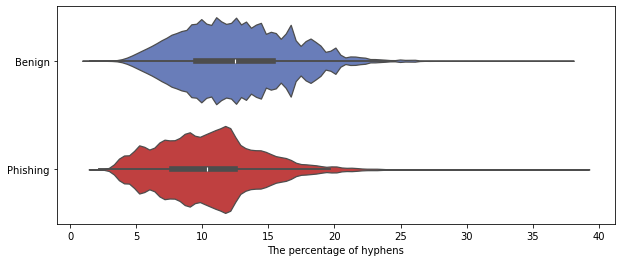

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Visualize the comparison using horizontal violin plots
for characteristic in padded_benign_data:
    plt.figure(figsize=(10, 4))  # Adjusted figure size for horizontal plot
    # Combine benign and phishing data into one DataFrame for plotting
    df = pd.DataFrame({
        'Benign': padded_benign_data[characteristic],
        'Phishing': padded_misp_data[characteristic]
    })

    # Melt the DataFrame for better visualization
    df_melted = df.melt(var_name='Domain Class', value_name=characteristic)

    # Plotting using horizontal violin plot
    ax = sns.violinplot(y='Domain Class', x=characteristic, data=df_melted, palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.5)
    #plt.title(f"The distribution of {characteristic}")
    ax.set_ylabel("")

    # Saving as PNG
    png_file_path = f"{image_path}/HorizontalViolinPlot_{characteristic}.png"
    plt.savefig(png_file_path, format='png', dpi=300)

    # Saving as PDF (vector format)
    pdf_file_path = f"{image_path}/HorizontalViolinPlot_{characteristic}.pdf"
    plt.savefig(pdf_file_path, format='pdf')

    plt.show()


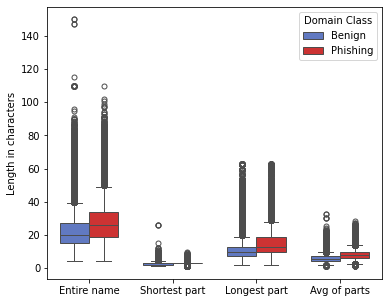

In [147]:
# Function to prepare data for boxplot
def prepare_boxplot_data(characteristics, benign_data, misp_data, max_length):
    data = {char: pad_list(benign_data[char], max_length) + pad_list(misp_data[char], max_length) 
            for char in characteristics}
    df = pd.DataFrame(data)
    domain_class = ['Benign'] * max_length + ['Phishing'] * max_length
    df['Domain Class'] = domain_class
    return df.melt(id_vars='Domain Class', var_name='Characteristic', value_name='Value')


# Modified characteristics for the first boxplot
first_plot_chars = ['Entire name', 'Shortest part', 'Longest part', 'Avg of parts']

first_plot_char_map = {
    'Entire name': 'Domain name length',
    'Shortest part': 'Shortest part length',
    'Longest part': 'Longest part length',
    'Avg of parts': 'Average part length'
}

first_plot_data = prepare_boxplot_data([first_plot_char_map[char] for char in first_plot_chars], benign_data, misp_data, max_length)

# Renaming characteristics for the first plot
first_plot_data['Characteristic'] = first_plot_data['Characteristic'].map(lambda x: {v: k for k, v in first_plot_char_map.items()}[x])


# Plotting the first boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(x='Characteristic', y='Value', hue='Domain Class', data=first_plot_data, 
            palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.6, width=0.7, dodge=0.1,
           fliersize=5, whis=1.0)
#plt.title('Domain Length Characteristics')
plt.ylabel('Length in characters')
plt.xlabel('')
plt.savefig(f"{image_path}/lex_lens.png", dpi=200)
plt.savefig(f"{image_path}/lex_lens.pdf", format='pdf')
plt.show()



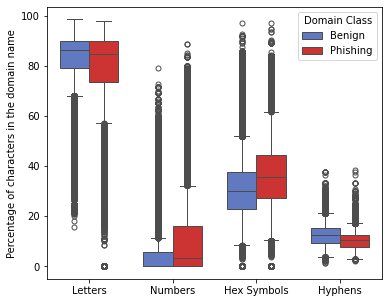

In [146]:
# Simplified names for the second boxplot characteristics
second_plot_chars = ['Letters', 'Numbers', 'Hex Symbols', 'Hyphens']
second_plot_char_map = {
    'Letters': 'The percentage of letters',
    'Numbers': 'The percentage of numbers',
    'Hex Symbols': 'The percentage of hex symbols',
    'Hyphens': 'The percentage of hyphens'
}
second_plot_data = prepare_boxplot_data([second_plot_char_map[char] for char in second_plot_chars], benign_data, misp_data, max_length)

# Renaming characteristics for the second plot
second_plot_data['Characteristic'] = second_plot_data['Characteristic'].map(lambda x: {v: k for k, v in second_plot_char_map.items()}[x])


# Plotting the second boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(x='Characteristic', y='Value', hue='Domain Class', data=second_plot_data, 
            palette={'Benign': 'royalblue', 'Phishing': 'red'}, saturation=0.6, width=0.7, dodge=0.1,
            fliersize=5, whis=1.0)
#plt.title('Character Type Percentages')

plt.ylabel('Percentage of characters in the domain name')
plt.xlabel('')

plt.savefig(f"{image_path}/lex_character_percentage.png", dpi=200)
plt.savefig(f"{image_path}/lex_character_percentage.pdf", format='pdf')
plt.show()


### Lexical domain analysis (Bigrams, Trigrams)

#### Init & definitions

In [97]:
from nltk import ngrams
import nltk
nltk.download('punkt') #   <----- RUN ONLY ONCE

[nltk_data] Downloading package punkt to C:\Users\Tomas
[nltk_data]     Foltyn\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [ ]:
def get_ngrams(domains, n):
    all_ngrams = []
    for domain in domains:
        tokens = nltk.word_tokenize(domain)
        n_grams = ngrams(tokens, n)
        all_ngrams.extend(n_grams)
    return all_ngrams

#### Compute and Plot the values

In [121]:
# Get bigrams and trigrams from the domain names
benign_bigrams = get_ngrams(benign_domains, 2)
misp_bigrams = get_ngrams(misp_domains, 2)

benign_trigrams = get_ngrams(benign_domains, 3)
misp_trigrams = get_ngrams(misp_domains, 3)

Top 10 Benign Bigrams: [(('rr1', '--'), 1648), (('rr2', '--'), 1600), (('rr3', '--'), 1328), (('rr4', '--'), 1159), (('rr5', '--'), 965), (('r1', '--'), 643), (('r2', '--'), 622), (('r3', '--'), 610), (('r4', '--'), 609), (('r5', '--'), 604)]
Top 10 MISP Bigrams: [(('xn', '--'), 63), (('1', '--'), 6), (('www', '--'), 6), (('--', 'wellsfargo'), 6), (('wellsfargo', '--'), 6), (('--', 'com'), 6), (('com', '--'), 6), (('--', 'smssssmsss.repl.co'), 5), (('--', 'promeriy.repl.co'), 4), (('--', 'p1ai'), 4)]
Top 10 Benign Trigrams: [(('--', '9hb.xn', '--'), 6), (('--', '9hbkg.xn', '--'), 6), (('--', 'production', '--'), 6), (('9hbkg.xn', '--', '9hb.xn'), 4), (('9hb.xn', '--', '9hb'), 3), (('xn', '--', '9hbcu.xn'), 3), (('--', '9hbcu.xn', '--'), 3), (('9hbcu.xn', '--', '9hbkg.xn'), 3), (('xn', '--', '9hbkg.xn'), 3), (('--', '8hb.xn', '--'), 3)]
Top 10 MISP Trigrams: [(('www', '--', 'wellsfargo'), 6), (('--', 'wellsfargo', '--'), 6), (('wellsfargo', '--', 'com'), 6), (('--', 'com', '--'), 6), ((

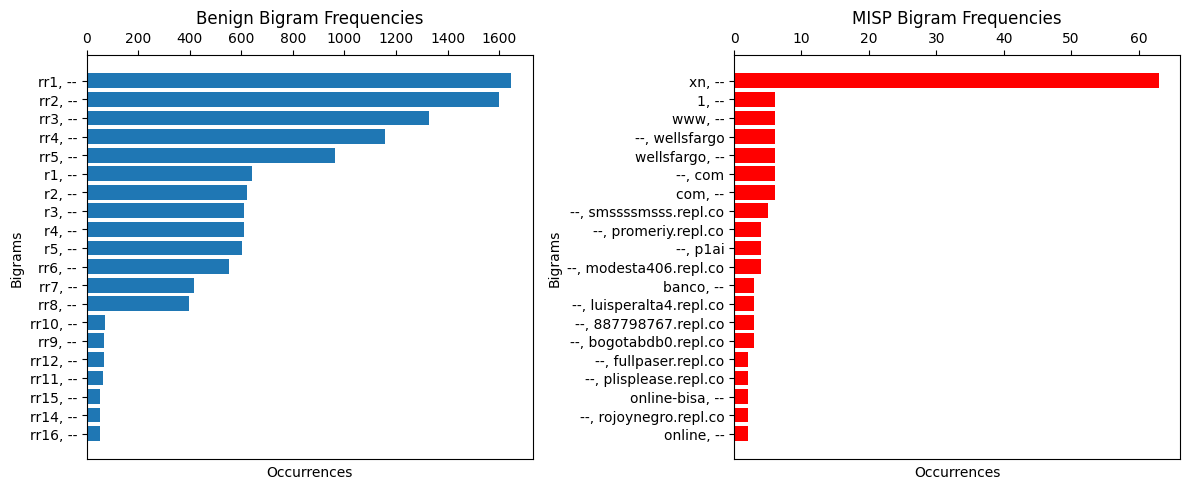

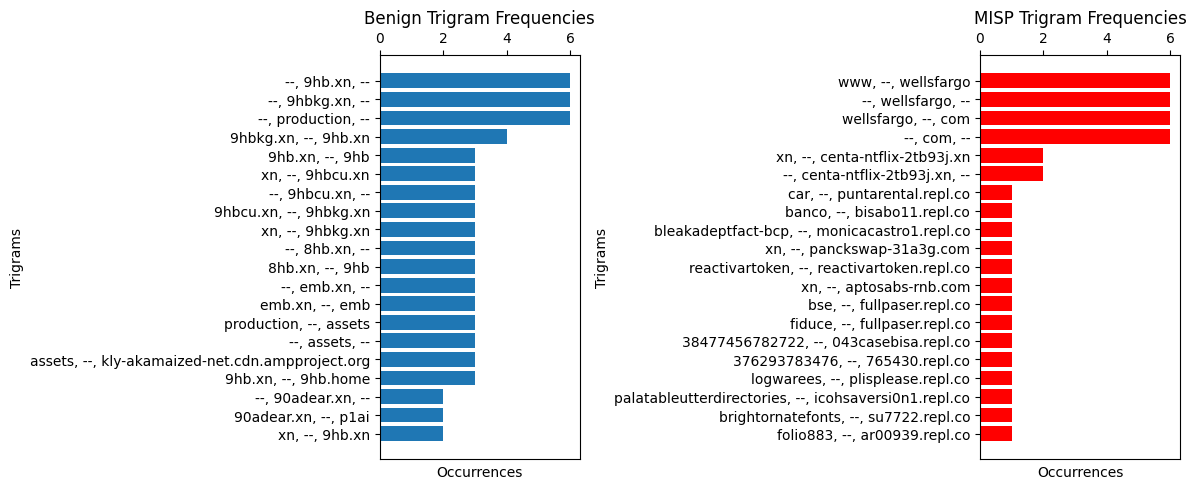

In [193]:
def plot_top_n_n_grams(benign_n_grams, misp_n_grams, top_n=20, ylabel=""):
    # Sort the bigrams by least common for both datasets
    counter_benign_bigrams = Counter(benign_n_grams).most_common(top_n)
    counter_misp_bigrams = Counter(misp_n_grams).most_common(top_n)
    
    total_benign_top_n = sum(count for _, count in counter_benign_bigrams)
    total_misp_top_n = sum(count for _, count in counter_misp_bigrams)
    
    total_benign_counts = len(benign_bigrams)
    total_misp_counts = len(misp_bigrams)
    
    # Extract bigram labels and counts for plotting
    benign_labels, benign_counts = zip(
        *reversed(counter_benign_bigrams)
    )
    misp_labels, misp_counts = zip(
        *reversed(counter_misp_bigrams)
    )
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.barh([", ".join(x) for x in benign_labels], benign_counts)
    plt.title(f'Benign {ylabel} Frequencies')
    plt.ylabel(ylabel+'s')
    plt.xlabel('Occurrences')
    plt.gca().xaxis.tick_top()
    
    plt.subplot(1, 2, 2)
    plt.barh([", ".join(x) for x in misp_labels], misp_counts, color="r")
    plt.title(f'MISP {ylabel} Frequencies')
    plt.ylabel(ylabel+'s')
    plt.xlabel('Occurrences')
    plt.gca().xaxis.tick_top()
    
    plt.tight_layout()
    plt.show()


plot_top_n_n_grams(benign_bigrams, misp_bigrams, ylabel="Bigram")
plot_top_n_n_grams(benign_trigrams, misp_trigrams, ylabel="Trigram")


## IP / RDAP

### Data init

#### Definitions (run all)

In [13]:
# WARNING! FUNCTION EXECUTES CODE!!!! 
# ONLY USE ON CSV FILES YOU KNOW ARE SAFE
def load_csv_dumped_column(x):
    if type(x) is list or type(x) is str:
        # because of the datetime, literal_eval throws an error 
        return eval(x)
    return None

def prepare_ip_data(df):
    # Explode the ip_data column
    df["og_id"] = df["_id"]
    df = df.explode("ip_data")
    df = df.dropna(subset=["ip_data"])

    # Flatten the ip_data column
    flattened = pd.json_normalize(df['ip_data'])
    flattened.reset_index(drop=True, inplace=True)
    
    # Create new IDs
    new_ids = range(len(flattened))
    
    # Map new IDs to original IDs
    id_mapping = dict(zip(new_ids, df["og_id"]))
    flattened["_id"] = flattened.index.map(id_mapping)

    # Join the flattened ip_data with the original DataFrame
    df = df.join(flattened, rsuffix='_flattened')

    return df

In [17]:
# run to save ip loaded and processed datasets
def save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips):
    benign_ips.to_csv('analysis_data/mongo/benign_ips.csv', index=False)
    misp_ips.to_csv('analysis_data/mongo/misp_ips.csv', index=False)
    w_misp_ips.to_csv('analysis_data/mongo/w_misp_ips.csv', index=False)
    w_benign_ips.to_csv('analysis_data/mongo/w_benign_ips.csv', index=False)

# run to load ip datasets (if there are any)
def load_ip_data():
    benign_ips = pd.read_csv('analysis_data/mongo/benign_ips.csv')
    misp_ips = pd.read_csv('analysis_data/mongo/misp_ips.csv')
    w_misp_ips = pd.read_csv('analysis_data/mongo/w_misp_ips.csv')
    w_benign_ips = pd.read_csv('analysis_data/mongo/w_benign_ips.csv')
    return benign_ips, misp_ips, w_benign_ips, w_misp_ips

#### Load cashed data from `/analysis_data/mongo/` (if there are any)

In [22]:
#save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)
#benign_ips, misp_ips, w_benign_ips, w_misp_ips = load_ip_data()

#### Load and prepare data (if not loaded already in previous block)

Load IP data from MongoDB into DataFrames. **takes a long time**

In [ ]:
load = True

if load:
    benign_ips = pd.DataFrame(list(benign.find({}, {"ip_data": 1})))
    misp_ips = pd.DataFrame(list(misp.find({}, {"ip_data": 1})))
    save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)
    
benign_ips, misp_ips, w_benign_ips, w_misp_ips = load_ip_data()

sample a percentage of the datasets to use for development (so test runs don't take ages)

In [ ]:
w_benign_ips = benign_ips.sample(frac=0.1)
w_misp_ips = misp_ips.sample(frac=1)

transrom the csv strings in 'ip_data' column into python literals. **NOT NEEDED, IF LOADED DIRECTLY FROM DB** 

In [ ]:
w_benign_ips['ip_data'] = w_benign_ips['ip_data'].apply(load_csv_dumped_column)
w_misp_ips['ip_data'] = w_misp_ips['ip_data'].apply(load_csv_dumped_column)

parse and shape the data into suitable form

In [ ]:
w_benign_ips = prepare_ip_data(w_benign_ips)
w_misp_ips = prepare_ip_data(w_misp_ips)

# at this point it would be suitable to call save_ip_data(benign_ips, misp_ips, w_benign_ips, w_misp_ips)

#### Print out some samples

In [ ]:
print(w_misp_ips.columns)
print(w_misp_ips['ip_data'].iloc[0])

### Analyse IPv4 percentage

#### Definitions

In [1]:
def average_ipv_percentage(source_df, version):
    df = source_df.copy()
    df.dropna(subset=["rdap.ip_version"])
    # Count the occurrences of IPv4 and IPv6 for each ID
    ipv4_ipv6_counts = df.groupby("_id_flattened")["rdap.ip_version"].value_counts().unstack(fill_value=0)

    # Calculate the percentage of IPv4 among the IDs
    ipv4_ipv6_counts["ipv4_percentage"] = (ipv4_ipv6_counts[version] / (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6]))
    # print(ipv4_ipv6_counts.shape)
    ipv4_ipv6_mask = (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6]) > 0
    ipv4_ipv6_counts = ipv4_ipv6_counts[ipv4_ipv6_mask]
    # print(ipv4_ipv6_mask.value_counts())
    ipv4_ipv6_counts["ipv4_percentage"].dropna()

    return ipv4_ipv6_counts["ipv4_percentage"]

def distribution_on_n_bins(df, n=10):
    bins = pd.cut(df, bins=n, labels=[round(x/n-1, 1) for x in range(n)])
    bins_counts = bins.value_counts().sort_index()
    return bins_counts / bins_counts.sum()


def dataset_ipv_percentage(source_df, version):
    df = source_df.copy()
    df.dropna(subset="rdap.ip_version")
    # Count the occurrences of IPv4 and IPv6
    ipv4_ipv6_counts = df["rdap.ip_version"].value_counts()
    return ipv4_ipv6_counts[version] / (ipv4_ipv6_counts[4] + ipv4_ipv6_counts[6])

def n_bin_percentage_scale(n):
    return [f"{round((x/n)*100)}-{round(((x+1)/n)*100)}%" for x in range(n)]

#### Calculate the values

In [2]:
# Calculate values
n_bins = 10

w_benign_ips_avg_ipv4 = average_ipv_percentage(w_benign_ips, 4)
w_benign_ipv4_dist = distribution_on_n_bins(w_benign_ips_avg_ipv4, n_bins)
w_misp_ips_avg_ipv4 = average_ipv_percentage(w_misp_ips, 4)
w_misp_ipv4_dist = distribution_on_n_bins(w_misp_ips_avg_ipv4, n_bins)
dataset_ipv4_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, 4), 3)
dataset_ipv4_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, 4), 3)

w_benign_ips_avg_ipv6 = average_ipv_percentage(w_benign_ips, 6)
w_misp_ips_avg_ipv6 = average_ipv_percentage(w_misp_ips, 6)
dataset_ipv6_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, 6), 3)
dataset_ipv6_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, 6), 3)


NameError: name 'w_benign_ips' is not defined

#### Plot the results

In [ ]:
# Create a figure with two subplots
def plot_ipv_n_distribution(n, w_benign_dist, w_misp_dist, dataset_percentage_benign, dataset_percentage_misp):
    other_n = 10 - n
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})
    
    df = pd.DataFrame(data={
        "index": n_bin_percentage_scale(n_bins),
        "Benign": w_benign_dist * 100,
        "Phishing": w_misp_dist * 100
    })
    df_melted = df.melt('index', var_name='Data Type', value_name='Value')
    
    # Plotting
    # plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='index', y='Value', hue='Data Type', data=df_melted, palette={'Benign': 'blue', 'Phishing': 'red'}, saturation=0.5, ax=axes[0])
    axes[0].set_xlabel(f'Percentage of IPv{n} addresses compared to IPv{other_n}')
    axes[0].set_ylabel('Density')
    yticks_labels = [label.get_text() + " %" for label in ax.get_yticklabels()]
    ax.set_yticklabels(yticks_labels)
    axes[0].set_title(f'Average IPv{n} Percentage Distribution: Benign vs. Phishing')
    axes[0].legend()
    
    
    # Create a narrow tall plot to the right
    bars = sns.barplot(x=['Benign', 'Phishing'], y=[dataset_percentage_benign, dataset_percentage_misp], hue=['Benign', 'Phishing'], ax=axes[1], palette=['b', 'r'], saturation=1, dodge=False, width=0.5)
    axes[1].set_ylabel(f'Dataset IPv{n} Percentage')
    # axes[1].set_xlabel('')
    axes[1].set_title(f'IPv{n} Presence (whole dataset)')
    axes[1].set_ylim(0, 100)
    yticks_labels = [label.get_text() + " %" for label in axes[1].get_yticklabels()]
    axes[1].set_yticklabels(yticks_labels)
    axes[1].bar_label(axes[1].containers[0], fontsize=10);
    
    # Add labels to both bars
    for container, label in zip(axes[1].containers, ['Benign', 'Phishing']):
        axes[1].bar_label(container, label=label, fontsize=10)
    
    plt.tight_layout()
    fig.savefig(f"{image_path}/Average IPv{n} Percentage Distribution_barplot.png")
    plt.show()


for n in [4, 6]:
    # calculate the average percentage of IPv{n} addresses in benign and misp
    w_benign_ips_avg = average_ipv_percentage(w_benign_ips, n)
    w_misp_ips_avg = average_ipv_percentage(w_misp_ips, n)
    # calculate the distributions
    w_benign_dist = distribution_on_n_bins(w_benign_ips_avg, n_bins)
    w_misp_dist = distribution_on_n_bins(w_misp_ips_avg, n_bins)
    # calculate the percentage of IPv{n} addresses on whole benign and misp datasets
    dataset_percentage_benign = round(dataset_ipv_percentage(w_benign_ips, n) * 100, 3)
    dataset_percentage_misp = round(dataset_ipv_percentage(w_misp_ips, n) * 100, 3)
    # plot the result
    plot_ipv_n_distribution(n, w_benign_dist, w_misp_dist, dataset_percentage_benign, dataset_percentage_misp)



### Other IP features

In [ ]:
# Function to analyze the distribution of ASNs
def asn_distribution(df):
    asns = df["ip_data.asn.asn"].explode().value_counts()
    return asns

# Function to analyze the distribution of ISPs
def isp_distribution(df):
    isps = df["ip_data.geo.isp"].explode().value_counts()
    return isps

# Function to analyze DNS record types distribution for each IP
def dns_record_types_distribution(df):
    dns_types = ['dns_A', 'dns_AAAA', 'dns_CNAME', 'dns_MX', 'dns_NS', 'dns_SOA', 'dns_TXT']
    dns_data = {dns_type: df[dns_type].apply(lambda x: len(x) if x else 0).sum() for dns_type in dns_types}
    return dns_data

# Function to analyze TLS protocols distribution for each IP
def tls_protocol_distribution(df):
    tls_protocols = df["tls.protocol"].explode().value_counts()
    return tls_protocols

# Function to analyze RDAP entity types distribution for each IP
def rdap_entity_types_distribution(df):
    entity_types = ['administrative', 'registrant', 'registrar', 'abuse', 'admin', 'technical']
    rdap_entities_data = {entity_type: df[f'rdap_entities.{entity_type}'].apply(lambda x: len(x) if x else 0).sum() for entity_type in entity_types}
    return rdap_entities_data

### GEO location

In [24]:
def compute_country_entropy(df):
    # Extract relevant columns
    id_country_data = df[["_id", "geo.country"]]

    # Drop rows with missing country data
    id_country_data = id_country_data.dropna(subset=["ip_data.geo.country"])

    # Group by ID and aggregate country data into lists
    id_country_groups = id_country_data.groupby("_id")["ip_data.geo.country"].agg(list)

    # Calculate country entropy for each ID
    entropy_values = id_country_groups.apply(lambda countries: entropy(np.unique(countries, return_counts=True)[1]))

    # Create a DataFrame with ID and corresponding entropy values
    entropy_df = pd.DataFrame({"_id": entropy_values.index, "country_entropy": entropy_values.values})

    return entropy_df



#### Countries

In [25]:
benign_top_n = 0.004
misp_top_n = 0.001

benign_tld_dist = calculate_column_distribution(w_benign_ips, "geo.country", benign_top_n)
misp_tld_dist = calculate_column_distribution(w_misp_ips, "geo.country", misp_top_n)

NameError: name 'w_benign_ips' is not defined

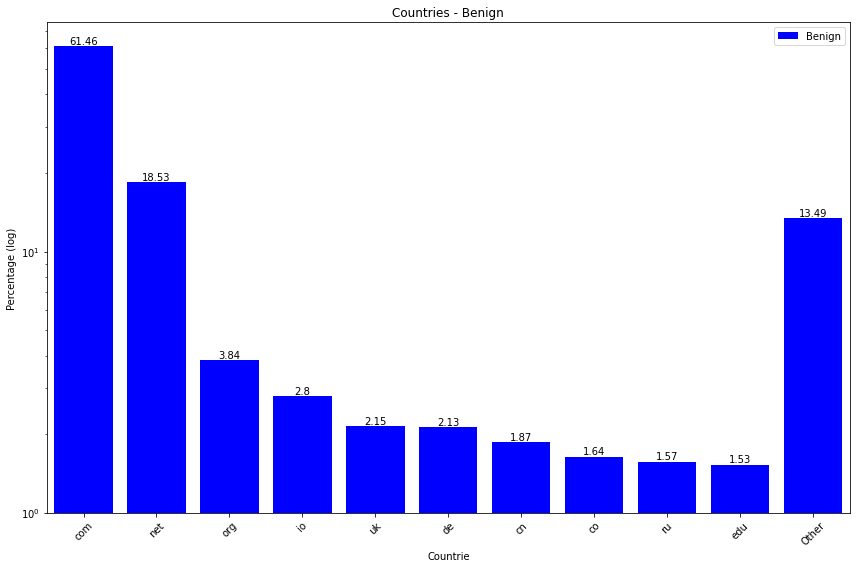

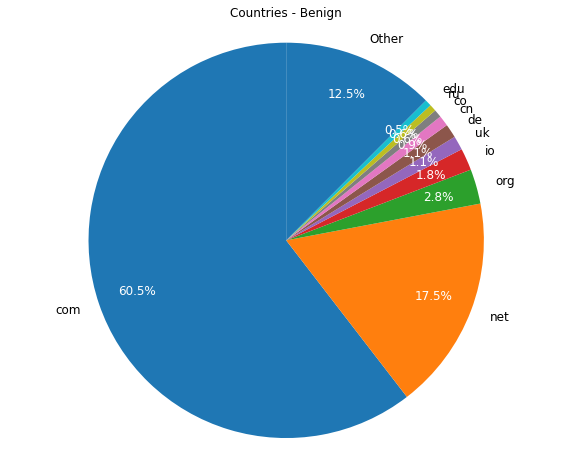

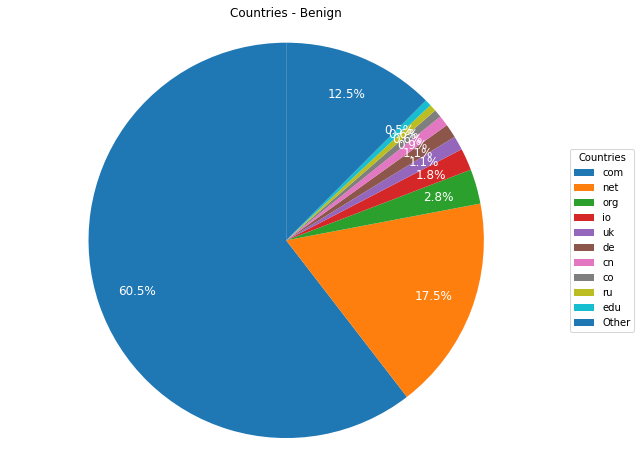

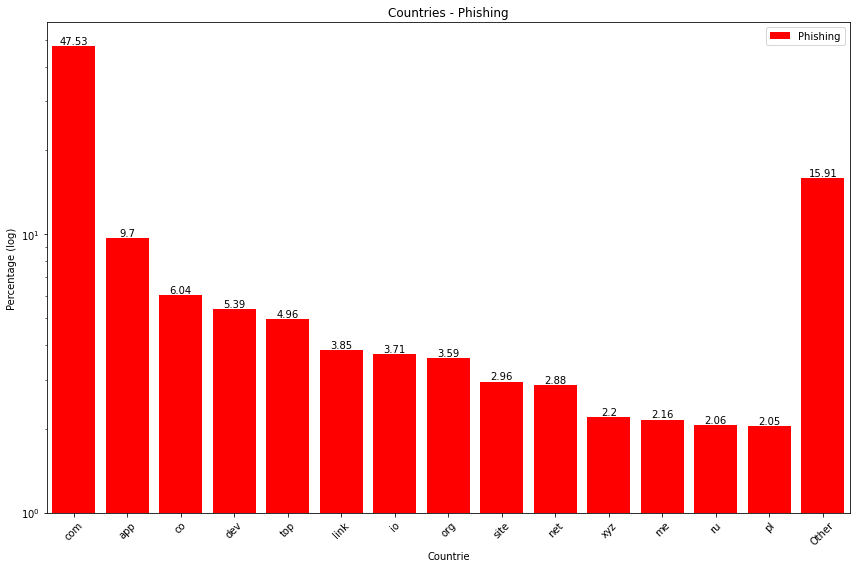

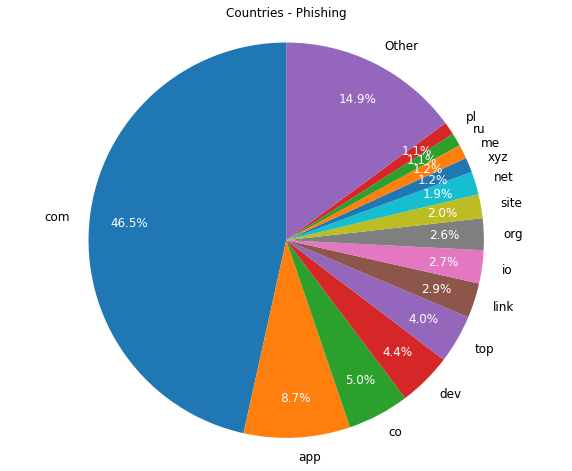

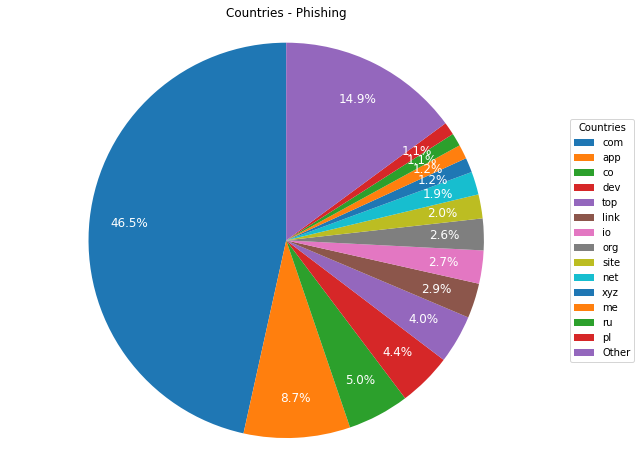

In [26]:
feature_name = "Countrie"
# Plot the Benign data
barplot_column_distribution(benign_tld_dist, feature_name, "Benign", color="b", log_scale=True, bottom=1e-0)
piechart_column_distribution(benign_tld_dist, feature_name, "Benign", color_map=plt.cm.Blues)
piechart_column_distribution(benign_tld_dist, feature_name, "Benign", color_map=plt.cm.Blues, legend=True)
# Plot the Phishing data
barplot_column_distribution(misp_tld_dist, feature_name, "Phishing", color="r", log_scale=True, bottom=1e-0)
piechart_column_distribution(misp_tld_dist, feature_name, "Phishing")
piechart_column_distribution(misp_tld_dist, feature_name, "Phishing", legend=True)

In [27]:
print(w_benign_ips["geo.country"].value_counts()[:10])

NameError: name 'w_benign_ips' is not defined

#### Countries the on World map

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt


# Extract latitude and longitude from the 'geo' field
w_benign_ips['Latitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_benign_ips['Longitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_benign_ips = w_benign_ips.dropna(subset=["Latitude"])
w_benign_ips = w_benign_ips.dropna(subset=["Longitude"])

w_misp_ips['Latitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_misp_ips['Longitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_misp_ips = w_misp_ips.dropna(subset=["Latitude"])
w_misp_ips = w_misp_ips.dropna(subset=["Longitude"])

# Create a GeoDataFrame
gdf_benign = gpd.GeoDataFrame(w_benign_ips, geometry=gpd.points_from_xy(w_benign_ips['Longitude'], w_benign_ips['Latitude']))
gdf_misp = gpd.GeoDataFrame(w_misp_ips, geometry=gpd.points_from_xy(w_misp_ips['Longitude'], w_misp_ips['Latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plot the world map
ax = world.plot(figsize=(15, 6), edgecolor='black', color='lightgray')

# Plot the scatter points on top of the world map
gdf_benign.plot(ax=ax, color='blue', marker='o', markersize=10, label='Benign')
gdf_misp.plot(ax=ax, color='red', marker='o', markersize=10, label='MISP')

# Set axis labels and title
ax.set_axis_off()
plt.title('IP Locations on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.savefig(f"{image_path}/IPs_scattered_on_map.png")
plt.show()


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `ip_data` is your DataFrame with the IP data schema

# Extract latitude and longitude from the 'geo' field
w_benign_ips['Latitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_benign_ips['Longitude'] = w_benign_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_benign_ips = w_benign_ips.dropna(subset=["Latitude"])
w_benign_ips = w_benign_ips.dropna(subset=["Longitude"])

w_misp_ips['Latitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('latitude') if x.get('geo') else None)
w_misp_ips['Longitude'] = w_misp_ips["ip_data"].apply(lambda x: x.get('geo').get('longitude') if x.get('geo') else None)
w_misp_ips = w_misp_ips.dropna(subset=["Latitude"])
w_misp_ips = w_misp_ips.dropna(subset=["Longitude"])

# Create a GeoDataFrame
gdf_benign = gpd.GeoDataFrame(w_benign_ips, geometry=gpd.points_from_xy(w_benign_ips['Longitude'], w_benign_ips['Latitude']))
gdf_misp = gpd.GeoDataFrame(w_misp_ips, geometry=gpd.points_from_xy(w_misp_ips['Longitude'], w_misp_ips['Latitude']))

# Load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(15, 6))
sns.set_theme(style="whitegrid")

# Plot the KDE for Benign IPs
sns.kdeplot(data=gdf_benign, x="Longitude", y="Latitude", fill=True, cmap="Blues", ax=ax, common_norm=False, levels=10, label='Benign')

# Plot the KDE for MISP IPs
sns.kdeplot(data=gdf_misp, x="Longitude", y="Latitude", fill=True, cmap="Reds", ax=ax, common_norm=False, levels=10, label='MISP')

# Plot the world map
world.plot(ax=ax, edgecolor='black', color='lightgray')

# Set axis labels and title
ax.set_axis_off()
plt.title('Kernel Density Estimate (KDE) on the World Map')

# Add a legend
plt.legend()

# Show the plot
plt.show()


# Tests

In [ ]:
data = {
    "_id": [1, 2, 3],
    "ip_data": [
        {"geo": {"country": "US"}},
        {"geo": {"country": "CA"}},
        {"geo": {"country": "US"}},
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

In [ ]:
test_misp_ips = w_misp_ips.copy()
# Explode the ip_data column
print(test_misp_ips.head())
test_misp_ips["og_id"] = test_misp_ips["_id"]
test_misp_ips = test_misp_ips.dropna(subset=["ip_data"])
test_misp_ips = test_misp_ips.apply(lambda row: pd.Series(row['ip_data']), axis=1).stack().reset_index(level=1, drop=True).reset_index()
test_misp_ips.columns = ['og_id', 'ip_data']

print(test_misp_ips.dtypes)
print(test_misp_ips)
# create new ids
test_misp_ips["_id"] = range(len(test_misp_ips))

# Flatten the ip_data column
test_misp_ips = pd.json_normalize(test_misp_ips['ip_data'])


In [41]:
test_misp_ips = w_misp_ips.copy()
test_misp_ips.iloc[3]["ip_data"]

"[{'ip': '18.130.80.173', 'from_record': 'A', 'remarks': {'rdap_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 36, 885000), 'asn_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 41, 67000), 'geo_evaluated_on': datetime.datetime(2023, 9, 10, 12, 22, 35, 841000), 'rep_evaluated_on': None, 'icmp_evaluated_on': datetime.datetime(2023, 8, 1, 17, 8, 41, 67000), 'is_alive': False, 'average_rtt': 0.0, 'ports_scanned_on': None}, 'rdap': {'handle': 'NET-18-130-0-0-2', 'parent_handle': 'NET-18-32-0-0-1', 'name': 'AMAZON-LHR', 'whois_server': 'whois.arin.net', 'type': 'ip network', 'terms_of_service_url': 'https://www.arin.net/resources/registry/whois/tou/', 'copyright_notice': 'Copyright 1997-2023, American Registry for Internet Numbers, Ltd.', 'description': [], 'last_changed_date': datetime.datetime(2021, 2, 10, 14, 46, 11), 'registration_date': datetime.datetime(2018, 2, 22, 21, 1, 30), 'expiration_date': None, 'url': 'https://rdap.arin.net/registry/ip/18.130.0.0', 'rir': 'arin', 'enti

In [200]:
test_misp_ips["rdap.ip_version"]

0        4.0
1        4.0
2        4.0
3        4.0
4        4.0
        ... 
50372    4.0
50373    4.0
50374    4.0
50375    4.0
50376    6.0
Name: rdap.ip_version, Length: 50377, dtype: float64

In [33]:
import pandas as pd

# Assuming 'ip_data' is a column containing lists
df = pd.DataFrame({
    '_id': [0, 1, 2],
    'ip_data': [[{'ip': '13.248.243.5'}, {'ip': '18.130.80.173'}], [], []]
})

df = df[df['ip_data'].apply(lambda x: bool(x))]

# Store the original id
df['og_id'] = df['_id']

# Explode the 'ip_data' column
df_exploded = df.apply(lambda row: pd.Series(row['ip_data']), axis=1).stack().reset_index(level=1, drop=True).reset_index()
df_exploded.columns = ['og_id', 'ip_data']

print(df_exploded)



   og_id                  ip_data
0      0   {'ip': '13.248.243.5'}
1      0  {'ip': '18.130.80.173'}


In [32]:
df_exploded["og_id"]

0    0
1    0
Name: og_id, dtype: int64